## Setup the default forcing

In [1]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
os.chdir("/home/149/ab8992/topographic-NIWs")
basepath = Path.cwd().absolute()

import autolib as al
# from dask.distributed import Client
# client = Client()
# client

## Make common forcing

In [ ]:
f = 1e-4
N = np.sqrt((9.8 * (42 / 1000)) / 4000)

print(N/f)

: 

In [2]:
import autolib as al


### COMMON ACROSS ALL EXPERIMENTS. 
##########################################################
nlayers = 20             # number of layers
Lx = 4000                # domain zonal extent [km]
Ly = 4000                # domain meridional extent [km]
H  = 4000                # total fluid's depth in [m]
gridspacing = 2          # in [km]
flat = False
reverse = True
x = np.arange(-Lx/2, Lx/2, gridspacing)
y = np.arange(-Ly/2, Ly/2, gridspacing)
ninterf = nlayers + 1    # number of interfaces
interfaces = np.arange(0,  ninterf)
nx = int(round(Lx/gridspacing))
ny = int(round(Ly/gridspacing))
overrides = ["ADIABATIC = True",
             "RHO_0 = 1025.0",
             f"NJGLOBAL={ny}",
             f"NIGLOBAL={nx}",
             f"LENLON = {Lx}.0",
             f"WESTLON = -{Lx//2}.0",
             f"LENLAT = {Ly}.0",
             f"WESTLAT = -{Ly//2}.0",
             f"NK = {nlayers}"]
default_dir = "default_rundir"


## Default values when unperturbed
default_height = 500 # m
default_forcing_latwidth = 300 # km
default_duration = 5 # hours
default_layerdensities = np.linspace(1025 - 21,1025 + 21,nlayers) ## This is the default stratification
default_strength = 1
default_ridge_width = 12.5 # km


## Value s from first pass! 
## Perterbation values
## strat variables 
strats = [0.25,0.2,0.5,0.75,1,1.25,1.5,2,3,4,0.001,0.01,6]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,600,750,1000,1250,1500,2000] + [500,650,700]

## Duration
durations = [0.5,1,2,3,4,5,6,8.7,10] + [7,8,12,14,15,16,20] ## Note! Will need to modify the amount of time that model runs for with forcing in this case

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10] + [5,6,7,8,9]

## Topog Width
widths = [4,8,12.5,16,25,35,50,100,200] + [75,125,150,300,400,500,600,700,800,1000]

## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,300,500,800,1000] + [250,400]

STRESS_X = al.windstress_gaussian(nx = nx,ny = ny)
eta_ridge = al.eta_gaussian_hill(
        nlayers=nlayers,
        ridge=True,
        nx = nx,
        ny = ny,
        )
   

## Save the common wind forcing


In [18]:
topo_file = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/inputdir/common/driver*.nc")
topo_file.Layer.values[0] = 1021
topo_file.eta[1,:,:] = -50

topo_file.to_netcdf("/home/149/ab8992/topographic-NIWs/inputdir/common/with_mixed_layer.nc")


In [19]:
topo_file = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/inputdir/common/driver*.nc")
topo_file

<xarray.Dataset> Size: 704MB
Dimensions:  (x: 2000, y: 2000, Layer: 20, interface: 21)
Coordinates:
  * x        (x) float64 16kB -2e+03 -1.998e+03 ... 1.996e+03 1.998e+03
  * y        (y) float64 16kB -2e+03 -1.998e+03 ... 1.996e+03 1.998e+03
  * Layer    (Layer) float64 160B 1.022e+03 1.022e+03 ... 1.028e+03 1.028e+03
Dimensions without coordinates: interface
Data variables:
    eta      (interface, y, x) float64 672MB dask.array<chunksize=(21, 2000, 2000), meta=np.ndarray>
    topo     (y, x) float64 32MB dask.array<chunksize=(2000, 2000), meta=np.ndarray>

In [30]:
topo_file.Layer.shape

(20,)

In [38]:
import xarray as xr
import numpy as np

# Load the dataset
topo_file = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/inputdir/common/driver*.nc")


# Assuming the new value to add is 0 (you can change this to any value you need)

# Create a new array with the additional value
new_interface_data = np.zeros(tuple(a + b for a,b in zip(topo_file.eta.shape, (1,0,0))))
new_interface_data[0,:,:] = topo_file.eta[0,:,:]
new_interface_data[1,:,:] = -50
new_interface_data[2:,:,:] = topo_file.eta[1:,:,:]

new_layers = np.zeros(21)
new_layers[0] = 1019
new_layers[1:] = topo_file.Layer.values

new_topo_file = xr.Dataset(
    {
        "eta": (("interface", "y","x"), new_interface_data),
        "topo": (("y","x"), topo_file.topo.values)
    },
    coords = {
        "x": topo_file.x.values,
        "y": topo_file.y.values,
        "Layer": new_layers
    }
)

new_topo_file.eta.attrs = topo_file.eta.attrs
new_topo_file.topo.attrs = topo_file.topo.attrs
new_topo_file.Layer.attrs = topo_file.Layer.attrs
new_topo_file.to_netcdf("/home/149/ab8992/topographic-NIWs/inputdir/common/with_mixed_layer.nc")


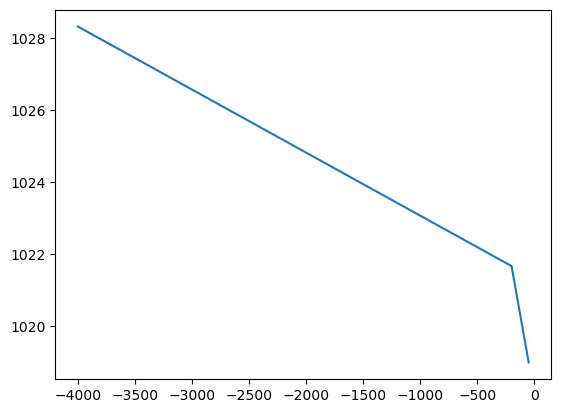

In [39]:
plt.plot(new_topo_file.eta[1:,0,0],new_topo_file.Layer)

In [34]:
topo_file

<xarray.Dataset> Size: 704MB
Dimensions:  (x: 2000, y: 2000, Layer: 20, interface: 21)
Coordinates:
  * x        (x) float64 16kB -2e+03 -1.998e+03 ... 1.996e+03 1.998e+03
  * y        (y) float64 16kB -2e+03 -1.998e+03 ... 1.996e+03 1.998e+03
  * Layer    (Layer) float64 160B 1.022e+03 1.022e+03 ... 1.028e+03 1.028e+03
Dimensions without coordinates: interface
Data variables:
    eta      (interface, y, x) float64 672MB dask.array<chunksize=(21, 2000, 2000), meta=np.ndarray>
    topo     (y, x) float64 32MB dask.array<chunksize=(2000, 2000), meta=np.ndarray>

In [ ]:
al.save_inputdata(
    x,
    y,
    STRESS_X,
    STRESS_X * 0,
    eta_ridge,
    "common",
    )


In [5]:
## Need to iterate through every run directory, change the project to v45 and run based on how much longer it needs to run for

for expt in ["duration","width","height"]:
    runs = (basepath / "rundirs" / expt).glob(f"{expt}*")
    for run in runs:
        al.overwrite_in_file(str(basepath / "rundirs" / expt / run / "config.yaml"),"project: nm03","project: v45")

        n_outputs = len([i for i in (basepath / "rundirs" / expt / run / "archive").glob("output*")])
        # print(run,n_outputs)
        if n_outputs < 11:
            # print(f"payu run -f -n {int(11 - n_outputs)}",
            #     str(basepath / "rundirs" / expt / run))
            subprocess.run(
                f"payu run -f -n {int(11 - n_outputs)}",
                shell=True,
                cwd = str(basepath / "rundirs" / expt / run)
            )

122660320.gadi-pbs
payu: warning: Job request includes 12 unused CPUs.
payu: warning: CPU request increased from 900 to 912
Loading input manifest: manifests/input.yaml
Loading restart manifest: manifests/restart.yaml
Loading exe manifest: manifests/exe.yaml
payu: Found modules in /opt/Modules/v4.3.0
qsub -q normal -P v45 -l walltime=21600 -l ncpus=912 -l mem=3648GB -N duration_1.5 -l wd -j n -v PAYU_PATH=/g/data/hh5/public/apps/miniconda3/envs/analysis3/bin,PAYU_N_RUNS=1,PAYU_FORCE=True,MODULESHOME=/opt/Modules/v4.3.0,MODULES_CMD=/opt/Modules/v4.3.0/libexec/modulecmd.tcl,MODULEPATH=/etc/scl/modulefiles:/opt/Modules/modulefiles:/opt/Modules/v4.3.0/modulefiles:/apps/Modules/modulefiles -W umask=027 -l storage=gdata/hh5+gdata/v45+scratch/v45 -- /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/bin/python3.10 /g/data/hh5/public/apps/miniconda3/envs/analysis3/bin/payu-run
122660321.gadi-pbs
payu: warning: Job request includes 12 unused CPUs.
payu: warning: CPU request increased from 